# Modeling the transition between exact coherent states of Plane Couette flow

_(B. Kaszás, M. Cenedese. Adapted from the live script https://github.com/haller-group/SSMLearn/tree/main/examples/couetteflow)_


These computations are described in the manuscript [3]. We take velocity fields generated by Channelflow [4] and build reduced order models which are able to capture the transition between dynamically relevant coherent states, with parametric dependance on the Reynolds number. We note that the results presented in the manuscript were obtained by processing the full velocity fields, which had resolution $(N_x, N_y, N_z) = (32, 35, 32)$.

In this notebook, simply to avoid having to upload large volumes of data, we use a compressed representation of the full flow fields by taking the projection to the first 20 PCA modes. Note that, due to the choice of our coordinates, this compression has no influence on the dynamical modeling. The full data is available from the authors upon request. 
We use data describing the transition between the three coexisting fixed points (or equilibria).  We denote the velocity field by

$$
\mathbf{u}(x,y,z,t) = \begin{pmatrix}u(x,y,z,t) \\
v(x,y,z,t) \\
w(x,y,z,t)
\end{pmatrix}.
$$

The laminar base state at the origin 

$$
\mathbf{u}(x,y,z,t) = \begin{pmatrix}y \\
0 \\
0
\end{pmatrix}
$$
is a stable fixed point in this flow. The lower and upper branch fixed points appear in a saddle-node bifurcation at $\text{Re}=134.50$. The lower branch is an unstable fixed point, while the upper branch is stable. In this notebook, we fix $\text{Re} = 135$, and conclude that a reduced-order model can be obtained by restricting the flow to a two-dimensional spectral submanifold (SSM) [5]. Indeed, there exists a unique, robust smoothest invariant manifold tangent to the least stable subspace of the stable fixed point. We choose to parametrize this manifold using the square root of the energy input rate $J = \sqrt{|I|}$ and that of the energy dissipation rate $K= \sqrt{|D|}$, where $I$ and $D$ are defined as

$$
I =  \frac{1}{2 L_x L_z} \int_0^{L_x} \int_0^{L_z} \left(\left.  \frac{\partial u}{\partial y}\right\vert_{y=1} + \left. \frac{\partial u}{\partial y}\right\vert_{y=-1}\right)\ \text{d}z \ \text{d}x-1, \\
    D = \frac{1}{2L_xL_z}\int_0^{L_x}\int_{-1}^1\int_0^{L_z}|\nabla \times \mathbf{u}|^2\  \text{d}z \ \text{d}y \ \text{d}x-1.
$$

With this definition, the rate of energy input  is equal to zero at the laminar base state. The use the square root  of  as parametrizing coordiates of the SSM is due to its capability to describe the spectral subspace of the SSM, while  suffers of a singularity issue near the laminar base state as pointed out in [3].

__Bibliography__:

[1] J. Page & R. R. Kerswell, Koopman mode expansions between simple invariant solutions, Journal of Fluid Mechanics 879, 1-27 (2019) 

[2] J. F. Gibson, J. Halcrow & P. Cvitanović, Visualizing the geometry of state space in plane Couette flow, Journal of Fluid Mechanics, 611, 107–130, (2008)

[3] B. Kaszás, M. Cenedese & G. Haller, Modeling transitions between exact coherent states in plane Couette flow, submitted, (2022)


[4] J. F. Gibson, Channelflow: A spectral Navier-Stokes simulator in C++, Tech. Rep. (U. New Hampshire, 2014) [Channelflow.org.](https://channelflow.ch)


[5] G. Haller & S. Ponsioen, Exact model reduction by a slow-fast decomposition of nonlinear mechanical systems. Nonlinear Dynamics 90, 617-647, (2017) 


[6] M. Cenedese, J. Axås, B. Bäuerlein, K. Avila & G. Haller, Data-driven modeling and prediction of non-linearizable dynamics via spectral submanifolds Nat. Commun. 13 872.  (2022) 

In [1]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
from ssmlearnpy.reduced_dynamics.advector import advect
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = loadmat('dataRe135.mat')
n_traj_train = 2
t_train = [mat['aData'][i][0].flatten() for i in range(n_traj_train)]
x_full_train = [mat['aData'][i][1] for i in range(n_traj_train)]
x_reduced_train = [np.sqrt(mat['xData'][i][1]) for i in range(n_traj_train)]
x_shift = -np.matmul(mat['pcaComponents'],mat['pcaMean'].T)
ini_Time, end_Time = 400, 1400
for i_traj in range(n_traj_train):
    t_i, x_i, x_r_i = t_train[i_traj], x_full_train[i_traj], x_reduced_train[i_traj]
    idx_Ini, idx_End = int(np.sum(t_i<ini_Time)), int(np.sum(t_i<end_Time))+1
    t_train[i_traj] = t_i[idx_Ini:idx_End]
    x_full_train[i_traj] = x_i[:,idx_Ini:idx_End]-x_shift
    x_reduced_train[i_traj] = x_r_i[:,idx_Ini:idx_End]

n_traj_test = len(mat['aData'])-n_traj_train
t_test = [mat['aData'][i][0].flatten() for i in range(n_traj_train,len(mat['aData']))]
x_full_test = [mat['aData'][i][1] for i in range(n_traj_train,len(mat['aData']))]
x_reduced_test = [np.sqrt(mat['xData'][i][1]) for i in range(n_traj_train,len(mat['aData']))]
ini_Time, end_Time = 100, 1400
for i_traj in range(n_traj_test):
    t_i, x_i, x_r_i = t_test[i_traj], x_full_test[i_traj], x_reduced_test[i_traj]
    idx_Ini, idx_End = int(np.sum(t_i<ini_Time)), int(np.sum(t_i<end_Time))+1
    t_test[i_traj] = t_i[idx_Ini:idx_End]
    x_full_test[i_traj] = x_i[:,idx_Ini:idx_End]-x_shift
    x_reduced_test[i_traj] = x_r_i[:,idx_Ini:idx_End]    


## Specifying the reduced coordinates 

In [2]:
ssm = SSMLearn(
    t = t_train, 
    x = x_full_train, 
    reduced_coordinates = x_reduced_train,
    ssm_dim=2, 
    dynamics_type = 'map'
)
ssm.get_parametrization(poly_degree=2)    
ssm.get_reduced_dynamics(poly_degree=4) 
ssm.predict()  

INFO   2023-07-25 23:01:28 ridge Transforming data
INFO   2023-07-25 23:01:28 ridge Skipping CV on ridge regression
INFO   2023-07-25 23:01:28 ridge Fitting regression model
INFO   2023-07-25 23:01:28 ridge Transforming data
INFO   2023-07-25 23:01:28 ridge Skipping CV on ridge regression
INFO   2023-07-25 23:01:28 ridge Fitting regression model


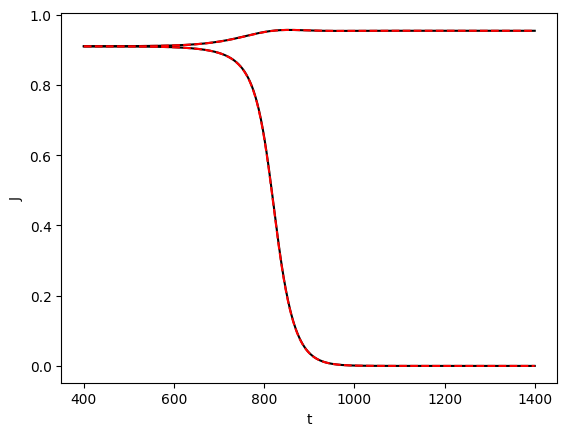

In [3]:
t_predict = ssm.reduced_dynamics_predictions['time']
x_predict = ssm.reduced_dynamics_predictions['reduced_coordinates']
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_train[i_traj], 
        x_reduced_train[i_traj][0,:],
        'k'
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'r--'
    )

plt.xlabel("t")
plt.ylabel("J")

plt.show()  

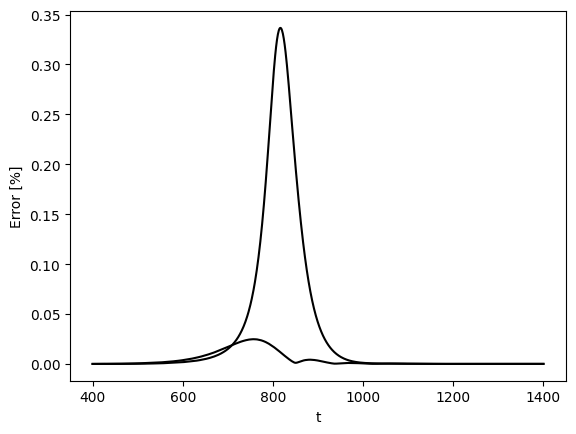

In [4]:
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")

plt.show()  

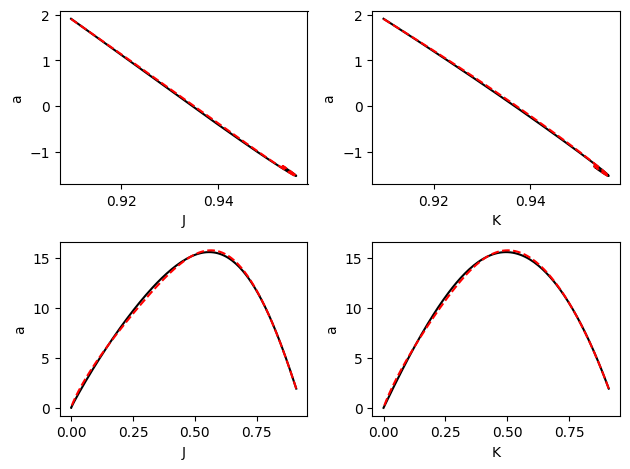

In [5]:
t_predict = ssm.predictions['time']
x_predict = ssm.predictions['observables']
e_predict = ssm.predictions['errors']

fig = plt.figure()
n_coord, idx_coord, c_plot = 2, 1, 0
x_labels = ['J', 'K']
for i_traj in range(n_traj_train):
    for i_coord in range(n_coord):
        c_plot = c_plot + 1
        ax = fig.add_subplot(n_coord, n_traj_train, c_plot)
        ax.plot(
            x_reduced_train[i_traj][i_coord,:], 
            x_full_train[i_traj][idx_coord,:],
            'k'
        )

        ax.plot(
            x_reduced_train[i_traj][i_coord,:],
            x_predict[i_traj][idx_coord,:],
            'r--'
        )

        ax.set_xlabel(x_labels[i_coord])
        ax.set_ylabel("a")
plt.tight_layout()
plt.show() 

### We can call ```ssm.predict()``` with test trajectories separately 

The model predicts the time-histories of the $J$ variable on the test set. 

In [7]:
%%time 
test_predictions = ssm.predict(t = t_test, x = x_full_test, x_reduced = x_reduced_test)  

CPU times: user 9.97 s, sys: 154 ms, total: 10.1 s
Wall time: 10.2 s


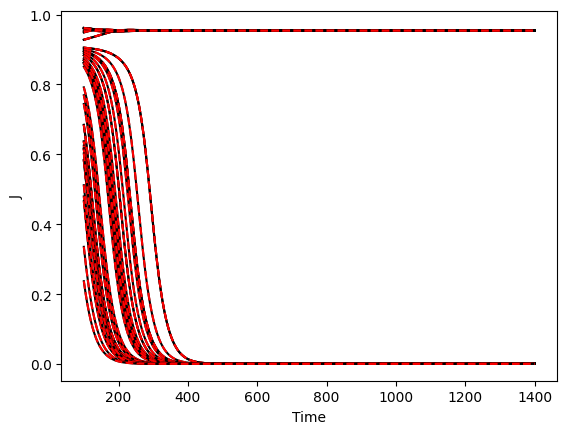

In [11]:
t_predict = test_predictions['time']
x_predict = test_predictions['reduced_coordinates']
e_predict = test_predictions['errors']
for i_traj in range(n_traj_test):
    plt.plot(
        t_test[i_traj], 
        x_reduced_test[i_traj][0,:],
        'k'
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'r--'
    )

plt.xlabel("Time")
plt.ylabel("J")

plt.show()  

Combining the predictions of the reduced order model with the parametrization, we obtain the net error. 

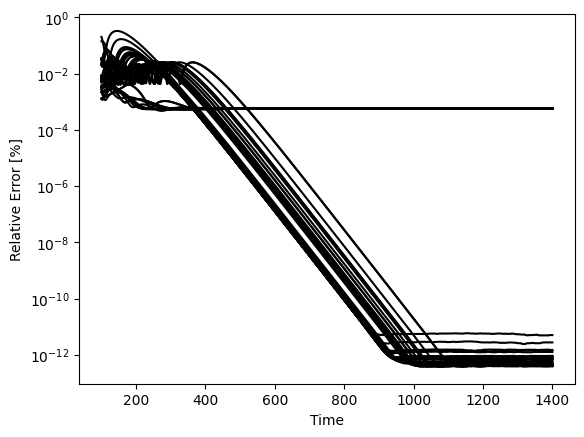

In [12]:
for i_traj in range(n_traj_test):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("Time")
plt.ylabel("Relative Error [%]")
plt.yscale("log")
plt.show()  